### Gaussian tests

- MFs shapes with Gaussian random fields (GRFs)

In [1]:
import healpy as hp
import numpy as np
import os
from cndreg2d import estimator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import special

- analytic gaussian MFs

In [2]:
from scipy import special

def V0(_x):
    return 0.5 - 0.5*special.erf(_x/np.sqrt(2.))

def V1(_x,_C):
    return _C*np.exp(-_x**2/2.)

def V2(_x,_C):
    return _C*_x*np.exp(-_x**2/2.)

- toy $C_\ell$ and MFs $V_{1,2}$ coefficients

In [3]:
## a toy Cl
def toycl(size, cutoff):
    cl = np.ones(size)
    cl[0] = 0
    for i in range(1,size):
        if (i < cutoff):
            cl[i] /= (i+1)**1.2
        else:
            cl[i] = 0
    return cl

# MFs V1 and V2 coefficients for the toy model
def toycl_c(size, cutoff):
    tmp1 = 0.
    tmp2 = 0.
    for i in range(1,size):
        if (i < cutoff):
            amplitude = 1./(i+1)**1.2
            tmp1 += (2*i+1)*amplitude
            tmp2 += i*0.5*(2*i+1)*(i+1)*amplitude
    return np.sqrt(tmp2/tmp1)/8., tmp2/tmp1/(np.sqrt(8.*np.pi**3))

- Gaussian scalar map realization from toy $C_\ell$

(0.0001, 10.0)

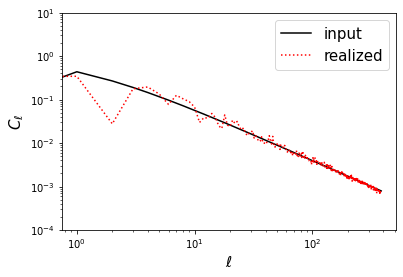

In [4]:
NSIDE = 128
NSIDE_MAX = 2048

tiral_cl = toycl(3*NSIDE_MAX,3*NSIDE)  # original Cl
trial_map = hp.synfast(tiral_cl,NSIDE,verbose=False)  # original map
test_cl = hp.anafast(trial_map)

fig, ax = plt.subplots()
ax.loglog(toycl(3*NSIDE,3*NSIDE),'k-',label=r'input')
ax.loglog(test_cl,'r:',label='realized')

ax.legend(loc=1,fontsize=15)
ax.set_ylabel(r'$C_\ell$',fontsize=15)
ax.set_xlabel(r'$\ell$',fontsize=15)
#ax.set_xlim((1,5*NSIDE))
ax.set_ylim((1e-4,1e+1))

- MFs with original map from Cls

In [5]:
NSIDE_MAX = 2048

def gmfs(set_nside, map_nside, mfs_threshold):
    '''
    Returns
    -------
    std_shredshold, v0, v1, v2
    '''
    _cl = toycl(3*NSIDE_MAX,3*set_nside)
    _map = hp.synfast(_cl,map_nside,verbose=False)
    _mask = np.ones_like(_map)
    map_path = 'newgaussianmap.fits'
    mask_path = 'nomask.fits'
    if os.path.isfile(map_path):
        os.remove(map_path)
    if os.path.isfile(mask_path):
        os.remove(mask_path)
    hp.write_map(map_path,_map,dtype=np.float64)
    hp.write_map(mask_path,_mask,dtype=np.float64)
    est = estimator('CND_REG2D', map_path, mask_path, map_nside, mfs_threshold)
    tmp = est.run()
    os.remove(map_path)
    os.remove(mask_path)
    return tmp[:,0], tmp[:,1], tmp[:,2], tmp[:,3]

def gmfs_ensemble(set_nside, map_nside, lv):
    N = 50  # ensemble size
    stot = np.zeros(N)
    v0tot = np.zeros((N,lv))
    v1tot = np.zeros((N,lv))
    v2tot = np.zeros((N,lv))
    for i in range(N):
        stot, v0tot[i], v1tot[i], v2tot[i] = gmfs(set_nside, map_nside, lv)
    return stot, v0tot, v1tot, v2tot

In [6]:
NSIDE = 16
RESCALE = 1

rslt = gmfs_ensemble(NSIDE, RESCALE*NSIDE, 20)

/usr/local/lib/python3.6/dist-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 16
ORDERING = RING in fits file


In [7]:
from scipy import optimize

kv1,pv1 = optimize.curve_fit(V1,rslt[0],np.mean(rslt[2],axis=0))
kv2,pv2 = optimize.curve_fit(V2,rslt[0],np.mean(rslt[3],axis=0))

c1, c2 = toycl_c(3*NSIDE_MAX,3*NSIDE)
print ('true C1',c1,'estimated C1',kv1,pv1)
print ('true C2',c2,'estimated C2',kv2,pv2)

true C1 2.3615781560999913 estimated C1 [1.94470512] [[0.00227463]]
true C2 22.662865304072813 estimated C2 [17.89897475] [[0.28452638]]


(-1.0, 1.0)

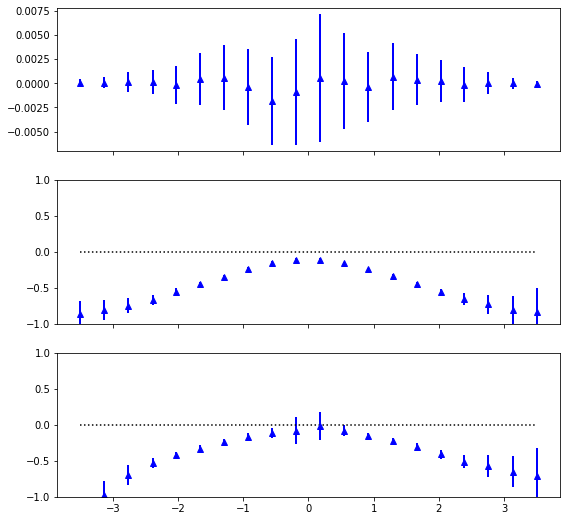

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(9,9), sharex=True)

ax[0].errorbar(rslt[0],np.mean(rslt[1],axis=0)-V0(rslt[0]),
               yerr=np.std(rslt[1],axis=0),
               fmt='^',color='b',elinewidth=2)
ax[1].errorbar(rslt[0],(np.mean(rslt[2],axis=0)-V1(rslt[0],c1))/(V1(rslt[0],c1)),
               yerr=np.std(rslt[2],axis=0)/(V1(rslt[0],c1)),
               fmt='^',color='b',elinewidth=2)
ax[2].errorbar(rslt[0],(np.mean(rslt[3],axis=0)-V2(rslt[0],c2))/(V2(rslt[0],c2)),
               yerr=np.std(rslt[3],axis=0)/(V2(rslt[0],c2)),
               fmt='^',color='b',elinewidth=2,label=r'$N_\mathrm{side}$ $128$')

ax[1].plot(rslt[0],np.zeros_like(rslt[0]),'k:')
ax[2].plot(rslt[0],np.zeros_like(rslt[0]),'k:')

ax[1].set_ylim((-1,1))
ax[2].set_ylim((-1,1))

end